In [1]:
from pathlib import Path
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import trange

from kgr import KGRModule

In [2]:
# attempt to enable LaTeX rendering
# change to `False` if you get an error during plotting (latex not installed)
plt.rcParams['text.usetex'] = True

In [3]:
def default_init_to_he_uniform(model):
    """ Change PyTorch's default initialization to He uniform """
    # PyTorch default uses 1/sqrt(m) as the bound
    # He uniform uses sqrt(3)/sqrt(m) as the bound
    sqrt3 = np.sqrt(3)
    for layer in model.modules():
        if isinstance(layer, torch.nn.Linear):
            layer.weight.data *= sqrt3
            layer.bias.data *= sqrt3


class MLP(nn.Module):
    """ MLP model """

    def __init__(self, input_size, hidden_size, num_hidden_layers=1, activation=torch.relu):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_size, 1)
        self.act = activation
        default_init_to_he_uniform(self)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.act(x)
        x = self.output_layer(x)
        return x

# Curve fitting

## Target

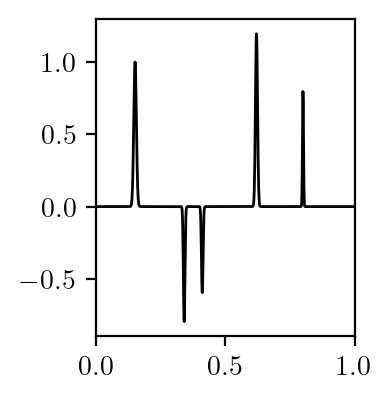

In [4]:
torch.set_default_dtype(torch.float32)


def gaussian(x, mu, sigma, height):
    """ Gaussian shape """
    exponent = -((x - mu) ** 2) / (2 * sigma ** 2)
    return height * torch.exp(exponent)


# ground truth
x_in = torch.linspace(0, 1, 1000)
y_true = torch.zeros_like(x_in)
y_true += gaussian(x_in, 0.15, 0.005, 1)
y_true -= gaussian(x_in, 0.34, 0.003, .8)
y_true -= gaussian(x_in, 0.41, 0.003, .6)
y_true += gaussian(x_in, 0.62, 0.004, 1.2)
y_true += gaussian(x_in, 0.8, 0.002, 0.8)
plt.figure(figsize=(3 / 1.8, 3.7 / 1.8), dpi=200)
plt.plot(x_in, y_true, lw=1, c="k")
plt.xlim(0, 1)
plt.savefig("figs/curve_target.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

## Training

In [5]:
def train(kgr, hidden_size, num_hidden_layers, seed, activation=torch.relu,
          num_epochs=10000, log_loss_every=20, device="cpu", pbar=True):
    """ Train a model """
    torch.manual_seed(seed)
    model = MLP(1, hidden_size=hidden_size, num_hidden_layers=num_hidden_layers,
                activation=activation)
    if kgr:
        is_input_skewed = activation is not torch.nn.functional.tanh
        model.input_layer = KGRModule(model.input_layer, is_input_skewed=is_input_skewed)
        model.output_layer = KGRModule(model.output_layer, is_input_skewed=is_input_skewed)
        for i_fc, fc in enumerate(model.hidden_layers):
            model.hidden_layers[i_fc] = KGRModule(fc, is_input_skewed=is_input_skewed)
    model.to(device)
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # training loop
    loss_hist = []
    x_in_ = x_in.unsqueeze(1).to(device)
    y_true_ = y_true.unsqueeze(1).to(device)
    for epoch in trange(num_epochs, disable=not pbar):
        y_pred = model(x_in_)
        loss = criterion(y_pred, y_true_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % log_loss_every == 0:
            loss_hist.append(loss.item())
    return model, loss_hist

In [15]:
# train all models
reproduce_paper = False
if reproduce_paper:
    """ THIS WILL TAKE A LONG TIME TO TRAIN THE 10x10x4x2 MODELS """
    seeds = list(range(10))
    nn_sizes = [(25, 1), (50, 1), (100, 1), (200, 1), (400, 1), (600, 1),
                (25, 2), (25, 3), (25, 4), (25, 5)]
    activations = [torch.nn.functional.relu, torch.nn.functional.leaky_relu,
                   torch.nn.functional.gelu, torch.nn.functional.tanh]
    epochs = 30000
    device_ = "cuda"
    out_dir = Path("results/curve_paper")
    show_pbar = False
else:
    seeds = [0]
    nn_sizes = [(200, 1)]
    activations = [torch.nn.functional.relu]
    epochs = 10000
    device_ = "cpu"
    out_dir = Path("results/curve_test")
    show_pbar = True

out_dir.mkdir(exist_ok=True, parents=True)
for seed_ in seeds:
    for act_ in activations:
        for hidden_size_, num_hidden_layers_ in nn_sizes:
            for kgr_ in [True]:
                act_name_ = "gelu" if act_ is torch.nn.functional.gelu else str(act_).split(" ")[1]
                name_ = f"{act_name_}_{seed_}_{hidden_size_}_{num_hidden_layers_}_{kgr_}"
                if not (out_dir / name_).exists() or True:
                    t0 = time()
                    _, hist_ = train(kgr_, hidden_size_, num_hidden_layers_, seed_, act_, device=device_,
                                     num_epochs=epochs, pbar=show_pbar)
                    np.savetxt(out_dir / name_, hist_)
                    print(f"{name_} trained in {(time() - t0) / 60:.1f} min, loss={hist_[-1]:.2e}")
                else:
                    print(f"{name_} exists")

AssertionError: Torch not compiled with CUDA enabled

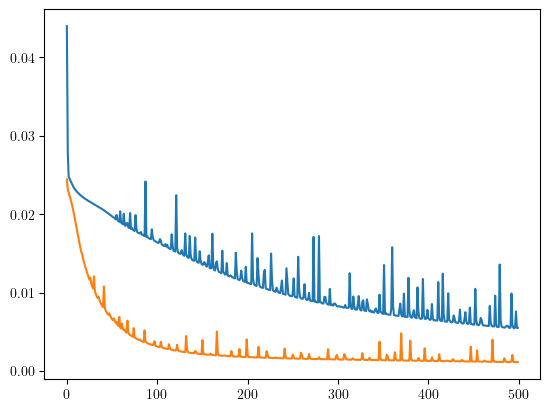

AssertionError: 

In [7]:
# quick comparison
hist_def = np.loadtxt(out_dir / "relu_0_200_1_False")
hist_kgr = np.loadtxt(out_dir / "relu_0_200_1_True")
plt.plot(hist_def)
plt.plot(hist_kgr)
plt.show()

## Analysis

The following cells works only when `reproduce_paper` was set `True` for training.

In [ ]:
seeds = list(range(10))
nn_sizes = [(25, 1), (50, 1), (100, 1), (200, 1), (400, 1), (600, 1),
            (25, 2), (25, 3), (25, 4), (25, 5)]
epochs = 30000
out_dir = Path("results/curve_paper")

### Loss statistics

In [ ]:
def get_metrics(act_name, kgi):
    min_loss_mean = []
    min_loss_std = []
    for hidden_size, num_hidden_layers in nn_sizes:
        hists = []
        for seed in seeds:
            name = f"{act_name}_{seed}_{hidden_size}_{num_hidden_layers}_{kgi}"
            hist = np.loadtxt(out_dir / name)
            hists.append(hist)
        hists = np.array(hists) * 1000
        min_loss = np.mean(hists[:, -5:], axis=1)
        min_loss = np.sort(min_loss)
        min_loss_mean.append(min_loss[:-4].mean())
        min_loss_std.append(min_loss[:-4].std())
    return np.array(min_loss_mean), np.array(min_loss_std)


fig, axes = plt.subplots(1, 4, figsize=(9, 1.6), dpi=200, sharex=True)
plt.subplots_adjust(wspace=.22)
for i, (act, act_str) in enumerate(zip(["relu", "leaky_relu", "gelu", "tanh"],
                                       ["ReLU", "LeakyReLU", "GELU", "Tanh"])):
    min_mean_def, min_std_def = get_metrics(act, False)
    min_mean_kgi, min_std_kgi = get_metrics(act, True)
    x_fake = range(len(min_mean_def))
    axes[i].errorbar(x_fake, min_mean_def, min_std_def, fmt="o",
                     markersize=3, capsize=2, capthick=1, elinewidth=1, label="No KGI", c="b")
    axes[i].errorbar(x_fake, min_mean_kgi, min_std_def, fmt="s",
                     markersize=3, capsize=2, capthick=1, elinewidth=1, label="KGI", c="r")
    axes[i].set_xticks(x_fake, ["25,1", "50,1", "100,1", "200,1", "400,1", "600,1",
                                "25,2", "25,3", "25,4", "25,5"])
    for label in axes[i].get_xticklabels():
        label.set_rotation(90)
    axes[i].set_xlabel("Width $W$, Depth $D$")
    axes[i].text(.5, 1.03, f"$\sigma$: {act_str}", va="bottom", ha="center",
                 transform=axes[i].transAxes)

axes[0].set_ylabel("MSE ($10^{-3}$)")
axes[0].legend()
axes[1].set_yticks([0, 5, 10])
axes[2].set_yticks([0, 5, 10])
axes[3].set_yticks([0, 1])
plt.savefig("figs/curve_loss_WD.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

### Loss history

In [ ]:
def moving_ave(series, window_size):
    """ Moving average to smooth the loss history a little bit """
    return np.convolve(series, np.ones(window_size) / window_size, mode='valid')


for act in ["relu", "leaky_relu", "gelu", "tanh"]:
    _, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(9, 2.5), dpi=200)
    plt.subplots_adjust(wspace=.15)
    for i, (hidden_size_, num_hidden_layers_) in enumerate(nn_sizes):
        seed_ = 0
        hist_def = np.loadtxt(out_dir / f"{act}_{seed_}_{hidden_size_}_{num_hidden_layers_}_{False}")
        hist_kgi = np.loadtxt(out_dir / f"{act}_{seed_}_{hidden_size_}_{num_hidden_layers_}_{True}")
        ax = axes[i // 5, i % 5]
        p = 5
        ax.plot(np.arange(epochs // 20 - p // 2 - 2), moving_ave(hist_def, p) * 1000, label="No KGI", lw=1, c='b')
        ax.plot(np.arange(epochs // 20 - p // 2 - 2), moving_ave(hist_kgi, p) * 1000, label="KGI", lw=1, c='r')
        ax.text(.5, .92, f"$W={hidden_size_}$", va="top", ha="left", transform=ax.transAxes)
        ax.text(.5, .78, f"$D={num_hidden_layers_}$", va="top", ha="left", transform=ax.transAxes)

    axes[0, 0].set_ylim(-3, 30)
    for i in range(2):
        axes[i, 0].set_ylabel("MSE ($10^{-3}$)")
        axes[i, 0].set_yticks([0, 10, 20, 30])
    for i in range(5):
        axes[1, i].set_xlabel("Epoch ($10^3$)")
        axes[1, i].set_xticks([0, 10000 // 20, 20000 // 20, 30000 // 20], [0, 10, 20, 30])
    if act == "relu":
        axes[0, 1].legend(ncol=2, loc=[0.03, 0.04], handlelength=.8, columnspacing=.5, handletextpad=.4)
    plt.savefig(f"figs/curve_loss_epoch_{act}.pdf", bbox_inches='tight', pad_inches=0.01)
    plt.show()

## Animate training

Now we zoom into the convergence process. Make sure you have `ffmpeg` installed.

In [8]:
def find_knots(y, dx, threshold=1e-11):
    """ Find indices of knots in a curve """
    if len(y) < 2:
        return []
    # calculate the slopes between consecutive points
    slopes = (y[1:] - y[:-1]) / dx
    # find where the slopes change
    slope_changes = torch.abs(torch.diff(slopes))
    knots = torch.where(slope_changes > threshold)[0] + 1  # noqa
    return knots.tolist()

In [10]:
def train_animate(kgr, hidden_size, num_hidden_layers, seed, activation=torch.relu,
                  num_epochs=50000, plot_every=20, device="cpu", pbar=True):
    """ Animate training """
    torch.manual_seed(seed)
    model = MLP(1, hidden_size, num_hidden_layers, activation)
    if kgr:
        is_input_skewed = activation is not torch.nn.functional.tanh
        model.input_layer = KGRModule(model.input_layer, is_input_skewed=is_input_skewed)
        model.output_layer = KGRModule(model.output_layer, is_input_skewed=is_input_skewed)
        for i_fc, fc in enumerate(model.hidden_layers):
            model.hidden_layers[i_fc] = KGRModule(fc, is_input_skewed=is_input_skewed)
    model.to(device)
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # output
    out = Path("results/curve_animation")
    out.mkdir(exist_ok=True, parents=True)

    # training loop
    x_in_ = x_in.unsqueeze(1).to(device)
    y_true_ = y_true.unsqueeze(1).to(device)
    for epoch in trange(num_epochs, disable=not pbar):
        y_pred = model(x_in_)
        loss = criterion(y_pred, y_true_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # plot a snapshot
        if (epoch + 1) % plot_every == 0 or epoch == 0:
            plt.figure(dpi=200)
            plt.plot(x_in, y_true, c='gray', lw=0.5)
            y_pred = y_pred.squeeze(1).detach().cpu()
            knots = find_knots(y_pred, x_in[1] - x_in[0], threshold=1e-3)
            plt.plot(x_in, y_pred, c='b', lw=1)
            plt.scatter(x_in[knots], y_pred[knots], marker="|", s=200, lw=1, c='r')
            plt.gca().axis("off")
            plt.text(0.6, 0.24, "KGR" if kgr else "No KGR", transform=plt.gca().transAxes, fontsize=16)
            plt.text(0.6, 0.17, f"Epoch = {epoch + 1}", transform=plt.gca().transAxes, fontsize=16)
            plt.text(0.6, 0.1, f"Loss = {loss.item():.1e}", transform=plt.gca().transAxes, fontsize=16)
            plt.savefig(out / f"{'KGR' if kgr else 'No_KGR'}_{(epoch + 1) // plot_every + 1}.png",
                        bbox_inches='tight', pad_inches=0.01)
            plt.close()

In [14]:
# change to `True` to generate animations in ./figs/
make_animations = False

if make_animations:
    train_animate(kgr=False, hidden_size=25, num_hidden_layers=2, seed=3)
    ffmpeg_command = (f"ffmpeg -i results/curve_animation/No_KGR_%d.png -c:v libx264 " +  # noqa
                      f"-framerate 24 -vf \'scale=trunc(iw/2)*2:trunc(ih/2)*2\' " +
                      f"-pix_fmt yuv420p -y figs/No_KGR.mp4")
    !{ffmpeg_command}

    train_animate(kgr=True, hidden_size=25, num_hidden_layers=2, seed=3)
    ffmpeg_command = (f"ffmpeg -i results/curve_animation/KGR_%d.png -c:v libx264 " +  # noqa
                      f"-framerate 24 -vf \'scale=trunc(iw/2)*2:trunc(ih/2)*2\' " +
                      f"-pix_fmt yuv420p -y figs/KGR.mp4")
    !{ffmpeg_command}

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57